Tsla.Csv 


848/848 - 17s - loss: 1.4744e-05 - accuracy: 0.0000e+00 - val_loss: 3.3557e-05 - val_accuracy: 0.0000e+00
Mean Absolute Error: 11.27
Mean Squared Error: 518.33
Root Mean Squared Error: 22.77
R2 Score:  0.9672190339100034
Btc-Usd.Csv 


82/82 - 8s - loss: 0.0013 - accuracy: 0.0122 - val_loss: 5.4686e-04 - val_accuracy: 0.0000e+00
Mean Absolute Error: 3716.28
Mean Squared Error: 27002479.45
Root Mean Squared Error: 5196.39
R2 Score:  0.40520855339485273
^Gspc.Csv 


128/128 - 6s - loss: 0.0074 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Mean Absolute Error: 174.28
Mean Squared Error: 43630.67
Root Mean Squared Error: 208.88
R2 Score:  0.5947671953515612


C:\Users\joao-\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\joao-\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


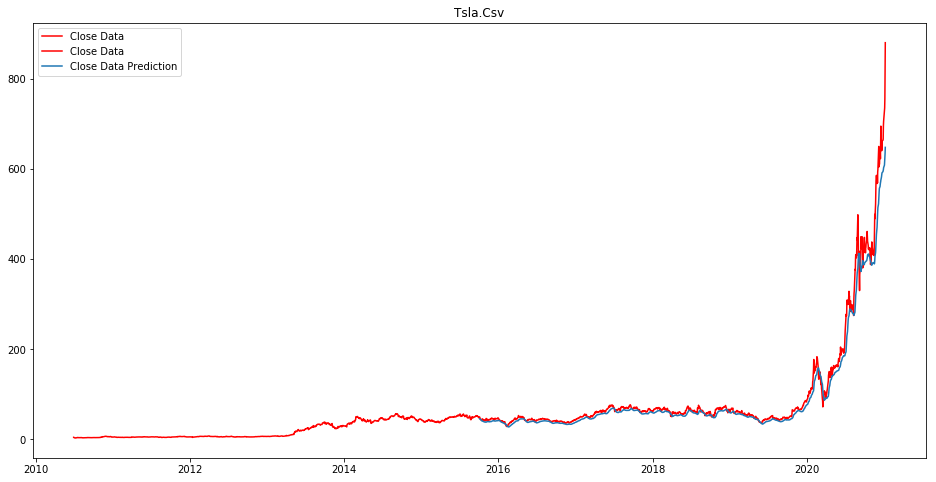

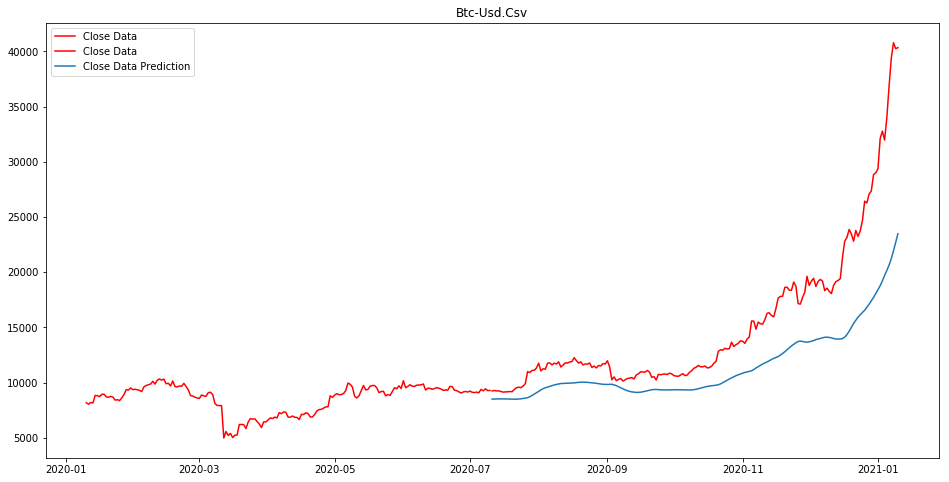

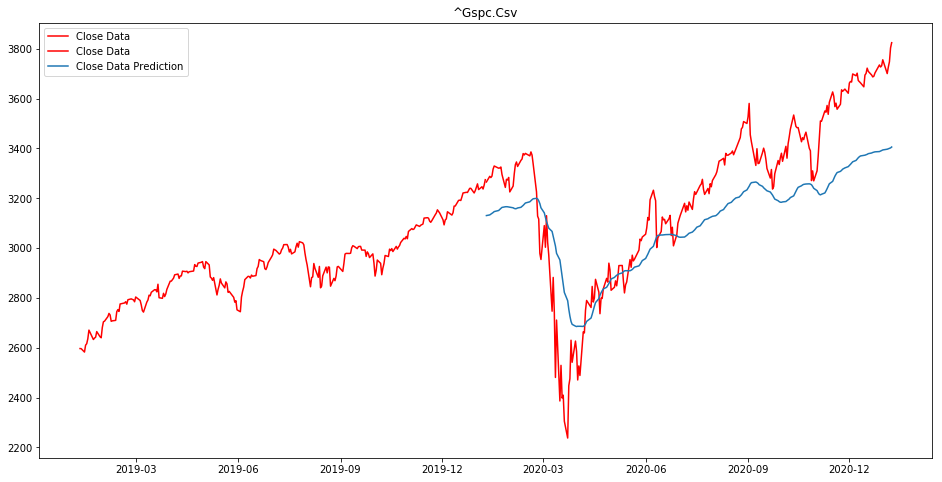

In [7]:
## Testing reading stocks dynamically

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dense



files = ['TSLA.csv', 'BTC-USD.csv', '^GSPC.csv']

def readCSV (csv):
    print(csv.title(),"\n\n")
    df=pd.read_csv(csv)
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']]
    df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
    df.index=df['Date']

    data=df.sort_index(ascending=True,axis=0)
    new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Adj Close'])

    for i in range(0,len(data)):
        new_dataset["Date"][i]=data['Date'][i]
        new_dataset["Adj Close"][i]=data["Adj Close"][i]


    final_dataset=new_dataset.values

    #Get array half length
    halfpoint = int(len(final_dataset)/2)
    train_data=final_dataset[:int(halfpoint)]
    valid_data=final_dataset[int(halfpoint):]

    new_dataset.index=new_dataset.Date
    new_dataset.drop("Date",axis=1,inplace=True)

    final_dataset=new_dataset.values
    #SCALE
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_data=scaler.fit_transform(final_dataset)

    x_train_data,y_train_data=[],[]

    for i in range(60,len(train_data)):
        x_train_data.append(scaled_data[i-60:i,0])
        y_train_data.append(scaled_data[i,0])

    x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

    x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))


    lstm_model=Sequential()
    lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
    lstm_model.add(LSTM(units=50))
    lstm_model.add(Dense(1))

    inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
    inputs_data=inputs_data.reshape(-1,1)
    inputs_data=scaler.transform(inputs_data)

    lstm_model.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])
    lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2,validation_split=0.33)


    X_test=[]
    for i in range(60,inputs_data.shape[0]):
        X_test.append(inputs_data[i-60:i,0])
    X_test=np.array(X_test)

    X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    predicted_closing_price=lstm_model.predict(X_test)
    predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

    train_data=new_dataset[:int(halfpoint)]
    valid_data=new_dataset[int(halfpoint):]
    valid_data['Predictions']=predicted_closing_price
    plt.figure(figsize=(16,8))
    plt.title(csv.title())
    plt.plot(train_data["Adj Close"], color='r', label='Close Data')
    plt.plot(valid_data['Adj Close'], color='r', label='Close Data')
    plt.plot(valid_data['Predictions'], label='Close Data Prediction')
    plt.legend()
    plt.show()

    mae= mean_absolute_error(valid_data["Adj Close"], valid_data["Predictions"])
    mse = mean_squared_error(valid_data["Adj Close"], valid_data["Predictions"])
    rmse = np.sqrt(mse)
    r2 = r2_score(valid_data["Adj Close"], valid_data["Predictions"])

    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Mean Squared Error: {:.2f}'.format(mse))
    print('Root Mean Squared Error: {:.2f}'.format(rmse))
    print('R2 Score: ', r2)


for x in files:
    readCSV(x)